In [163]:
import dlc_practical_prologue as prologue
#直接导入出现http403错误
from six.moves import urllib

In [164]:
import torch
import time
from torch import nn
from torch.nn import functional as F
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [165]:
# 直接导入出现http403错误
# have to add a header to your urllib request (due to that site moving to Cloudflare protection)
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
#*********************** 

In [166]:
# load data
N_PAIRS = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N_PAIRS)

In [167]:
train_input.shape

torch.Size([1000, 2, 14, 14])

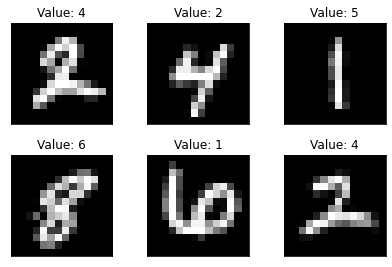

In [168]:
# displaying samples of data
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(test_input[i][0], cmap='gray')
  plt.title("Value: {}".format(train_classes[i][0]))  
  plt.tight_layout()
  plt.xticks([])
  plt.yticks([])

In [169]:
# plt.imshow(train_input[0][1],cmap='gray')
# plt.show()

In [170]:
print(train_input.shape)
print(train_input.dtype)
print(train_target.shape)
print(train_target.dtype)

torch.Size([1000, 2, 14, 14])
torch.float32
torch.Size([1000])
torch.int64


In [173]:
#CNN
class CNN_Net(nn.Module):
    def __init__(self):
        super(CNN_Net, self).__init__()
        self.conv1 = nn.Conv2d(2, 64, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,128,kernel_size=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2_drop=nn.Dropout2d()
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 2)
        #parameters
        self.batch_size = 50
        self.criterion = nn.CrossEntropyLoss()
        self.num_epochs = 25
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 512)))
        x = F.dropout(x,training=self.training)
        x = self.fc2(x)
        return x

        # Training Function

    def trainer(self, train_input, train_target):
        """
        Train the model on a training set
        :param train_input: Training features
        :param train_target: Training labels
        """
        start_time = time.time()
        self.train()
        for epoch in range(self.num_epochs):
            for batch_idx in range(0,train_input.size(0),self.batch_size):
                output = self(train_input[batch_idx:batch_idx+self.batch_size]) 
                loss = self.criterion(output, train_target[batch_idx:batch_idx+self.batch_size])  
                self.optimizer.zero_grad()                          #清零梯度
                loss.backward()                                #反向求梯度
                self.optimizer.step()
#                 每隔50组数据，输出一次loss值
                if not batch_idx % 50:
                    print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.6f' 
                           %(epoch+1, self.num_epochs, batch_idx, 
                             len(train_input), loss))
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
        

        # Test error

    def compute_error(self, input_data, target):
        """
        Compute the number of error of the model on a test set
        :param input_data: test features
        :param target: test target
        :return: error rate of the input data
        """  
    
        #测试模型
        self.eval()      #测试模式，关闭正则化
        errors = 0
        for idx in range(0,input_data.size(0),self.batch_size):
            input_batch=input_data.narrow(0,idx,self.batch_size)
            outputs = self(input_batch)
            _, predicted = torch.max(outputs, 1)   #返回值和索引
            target_labels = target.narrow(0, idx, self.batch_size)
            errors += torch.sum(predicted != target_labels)

        return float(errors)*100/input_data.size(0)
    def save_model(self,model_name):
        """
        Save the model to a direction
        :param model_name: the model name, e.g. CNN_Net.pth
        """         
        torch.save(self, './model/'+ model_name)

In [174]:
my_model=CNN_Net()
my_model.save_model('CNN_Net.pth')

In [175]:
# train the model
my_model.trainer(train_input, train_target)

Epoch: 001/025 | Batch 000/1000 | Loss: 0.718260
Epoch: 001/025 | Batch 050/1000 | Loss: 0.727345
Epoch: 001/025 | Batch 100/1000 | Loss: 0.784436
Epoch: 001/025 | Batch 150/1000 | Loss: 0.640804
Epoch: 001/025 | Batch 200/1000 | Loss: 0.683480
Epoch: 001/025 | Batch 250/1000 | Loss: 0.639555
Epoch: 001/025 | Batch 300/1000 | Loss: 0.686323
Epoch: 001/025 | Batch 350/1000 | Loss: 0.757853
Epoch: 001/025 | Batch 400/1000 | Loss: 0.639212
Epoch: 001/025 | Batch 450/1000 | Loss: 0.695754
Epoch: 001/025 | Batch 500/1000 | Loss: 0.653220
Epoch: 001/025 | Batch 550/1000 | Loss: 0.626454
Epoch: 001/025 | Batch 600/1000 | Loss: 0.556833
Epoch: 001/025 | Batch 650/1000 | Loss: 0.643307
Epoch: 001/025 | Batch 700/1000 | Loss: 0.552047
Epoch: 001/025 | Batch 750/1000 | Loss: 0.627101
Epoch: 001/025 | Batch 800/1000 | Loss: 0.590212
Epoch: 001/025 | Batch 850/1000 | Loss: 0.553420
Epoch: 001/025 | Batch 900/1000 | Loss: 0.567891
Epoch: 001/025 | Batch 950/1000 | Loss: 0.551793
Time elapsed: 0.01 m

Epoch: 009/025 | Batch 650/1000 | Loss: 0.379087
Epoch: 009/025 | Batch 700/1000 | Loss: 0.391804
Epoch: 009/025 | Batch 750/1000 | Loss: 0.116681
Epoch: 009/025 | Batch 800/1000 | Loss: 0.035463
Epoch: 009/025 | Batch 850/1000 | Loss: 0.074433
Epoch: 009/025 | Batch 900/1000 | Loss: 0.251370
Epoch: 009/025 | Batch 950/1000 | Loss: 0.265512
Time elapsed: 0.06 min
Epoch: 010/025 | Batch 000/1000 | Loss: 0.141251
Epoch: 010/025 | Batch 050/1000 | Loss: 0.114770
Epoch: 010/025 | Batch 100/1000 | Loss: 0.066596
Epoch: 010/025 | Batch 150/1000 | Loss: 0.054471
Epoch: 010/025 | Batch 200/1000 | Loss: 0.180847
Epoch: 010/025 | Batch 250/1000 | Loss: 0.154173
Epoch: 010/025 | Batch 300/1000 | Loss: 0.181106
Epoch: 010/025 | Batch 350/1000 | Loss: 0.050076
Epoch: 010/025 | Batch 400/1000 | Loss: 0.025160
Epoch: 010/025 | Batch 450/1000 | Loss: 0.026014
Epoch: 010/025 | Batch 500/1000 | Loss: 0.061199
Epoch: 010/025 | Batch 550/1000 | Loss: 0.191244
Epoch: 010/025 | Batch 600/1000 | Loss: 0.0842

Epoch: 018/025 | Batch 200/1000 | Loss: 0.002300
Epoch: 018/025 | Batch 250/1000 | Loss: 0.003049
Epoch: 018/025 | Batch 300/1000 | Loss: 0.001157
Epoch: 018/025 | Batch 350/1000 | Loss: 0.002336
Epoch: 018/025 | Batch 400/1000 | Loss: 0.001050
Epoch: 018/025 | Batch 450/1000 | Loss: 0.001316
Epoch: 018/025 | Batch 500/1000 | Loss: 0.001660
Epoch: 018/025 | Batch 550/1000 | Loss: 0.001214
Epoch: 018/025 | Batch 600/1000 | Loss: 0.001472
Epoch: 018/025 | Batch 650/1000 | Loss: 0.001986
Epoch: 018/025 | Batch 700/1000 | Loss: 0.001007
Epoch: 018/025 | Batch 750/1000 | Loss: 0.002125
Epoch: 018/025 | Batch 800/1000 | Loss: 0.001008
Epoch: 018/025 | Batch 850/1000 | Loss: 0.002647
Epoch: 018/025 | Batch 900/1000 | Loss: 0.000878
Epoch: 018/025 | Batch 950/1000 | Loss: 0.001206
Time elapsed: 0.12 min
Epoch: 019/025 | Batch 000/1000 | Loss: 0.001488
Epoch: 019/025 | Batch 050/1000 | Loss: 0.001890
Epoch: 019/025 | Batch 100/1000 | Loss: 0.001730
Epoch: 019/025 | Batch 150/1000 | Loss: 0.0020

In [178]:
# output the train error and test error
print("Train error : %.1f%% \nTest error : %.1f%%" %
      (my_model.compute_error(train_input, train_target),
       my_model.compute_error(test_input, test_target)))

print("The total number of the parameters is: %d" % (sum(p.numel() for p in my_model.parameters())))

Train error : 0.0% 
Test error : 16.1%
The total number of the parameters is: 102466
